- [Content Filtering](#content)
 - [Genre Similarities](#genre_sim)
 - [Summary Comparisons](#summary)
- [Collaborative Filtering](#collab)
 - [User Profiles](#profile)
 - [Collaborate User Ratings](#user)
 -[Predict User Score](#predict)
- [Scikit Surprise Models](#scikit)

# PreProcess

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score as jscore
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds 
from nltk.corpus import stopwords as sw
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

# Reviews

In [2]:
reviews_df = pd.read_csv('metacritic_reviews_main.csv').drop(['Unnamed: 0'],axis=1)
reviews_df.head()

,ids,name,game,rating,review
0,118429,ThomasR.,Combat Mission: Barbarossa to Berlin,9,Needs a brush-up on the graphics.
1,58304,JoaquinD.,Combat Mission: Barbarossa to Berlin,10,Perfect strategic and tactical WWII wargame. ...
2,78199,MichaelDorosh,Combat Mission: Barbarossa to Berlin,10,"Still the gold standard for WEGO, squad-based,..."
3,143673,dinin70,Combat Mission: Barbarossa to Berlin,9,I don't think it deserves 10/10 for a simple r...
4,14454,BlueFalcon,NHL 2002,6,"I was hyped about this release at the time, b..."


In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555661 entries, 0 to 555660
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ids     555661 non-null  int64 
 1   name    555650 non-null  object
 2   game    555661 non-null  object
 3   rating  555661 non-null  int64 
 4   review  555308 non-null  object
dtypes: int64(2), object(3)
memory usage: 21.2+ MB


In [4]:
reviews_df[reviews_df['name'].isna()]

,ids,name,game,rating,review
42046,-1,NaN,Diablo III,4,Stay awhile and listen to my whining. If you t...
65948,-1,NaN,Resident Evil 5,5,Co-op is the only thing that makes this game ...
108234,-1,NaN,The Walking Dead: Episode 1 - A New Day,8,I'm not a big fan of the TV series that goes w...
147609,-1,NaN,Enslaved: Odyssey to the West,6,I haven't finished Enslaved completely and I'l...
148608,-1,NaN,Hitman: Absolution,6,Hitman: Absolution fails to be a great game be...
233870,167115,NaN,Diablo III,4,Stay awhile and listen to my whining. If you t...
257821,82685,NaN,Resident Evil 5,5,Co-op is the only thing that makes this game ...
300222,167115,NaN,The Walking Dead: Episode 1 - A New Day,8,I'm not a big fan of the TV series that goes w...
340348,167115,NaN,Enslaved: Odyssey to the West,6,I haven't finished Enslaved completely and I'l...
341543,167115,NaN,Hitman: Absolution,6,Hitman: Absolution fails to be a great game be...


These are actually duplicate rows but for some reason the ids did not get duplicated. This actually works out since we'll only need the ids anyway. Lets do a little research just to be sure.

In [5]:
# get rid of rows with ids=-1
reviews = reviews_df.sort_values('ids').iloc[5:,:]

In [6]:
reviews = reviews.drop_duplicates().reset_index().iloc[:,1:]
reviews = reviews.iloc[:,[0,2,3,4]].drop(416615).reset_index(drop=True)
reviews = reviews.drop_duplicates(['ids', 'game'])
reviews

,ids,game,rating,review
0,0,Rockstar Games presents Table Tennis,9,Amazingly Addicting!
1,0,Disney's Magical Mirror Starring Mickey Mouse,10,this game lets you able to play as mickey mou...
2,1,Deus Ex: Invisible War,1,Yet another disappointment to add to 2003's r...
3,2,Mobile Suit Gundam: Journey to Jaburo,10,I love this Game!
4,3,Dead to Rights: Reckoning,10,This is a really good game for people ...
...,...,...,...,...
416613,186351,Enthusia Professional Racing,10,I think this game is better than GT4 because ...
416614,186352,Crash Bandicoot 2: N-Tranced,10,It's just great. It is very original and you'...
416615,186353,RollerCoaster Tycoon: Loopy Landscapes,10,"Perfect! No blood, no terror. Tüm dünyaca oyn..."
416616,186354,Dominions 3: The Awakening,8,Dominions is a very special 4X fantasy game in...


In [7]:
# reviews.to_csv('metacritic_reviews.csv')

In [8]:
# look at how many users rated more than 1 game
reviews['ids'].value_counts()[reviews['ids'].value_counts()>1]

131893    1122
16496      854
112980     540
128382     512
117211     488
          ... 
185107       2
171310       2
40132        2
21108        2
38220        2
Name: ids, Length: 51431, dtype: int64

51,431 users rated more than 1 game. This dataset should be sufficient enough for user comparisons

In [9]:
# Games with the most amount of ratings 
game_frequency = reviews['game'].value_counts()
game_frequency[:10]

Grand Theft Auto V                 640
Call of Duty: Ghosts               489
DOOM                               427
Resident Evil 4                    425
Resident Evil 2                    413
Resident Evil 6                    401
The Elder Scrolls V: Skyrim        401
Borderlands 2                      398
Cyberpunk 2077                     392
Assassin's Creed IV: Black Flag    390
Name: game, dtype: int64

Unfortunately I did not collect the platforms to each game title. Therefore, titles on multiple platforms will generally have more ratings because they are being lumped together based on title alone

In [10]:
# Distribution of ratings
reviews['rating'].value_counts()

10    121107
9      68901
8      53499
0      35459
7      31135
6      20805
5      17784
4      14907
3      13171
1      13007
2      11616
Name: rating, dtype: int64

This makes sense as people are more inclined to leave a review if they really like a game or if they hate it with a passion than if they only think the game is decent.

In [49]:
# Quick look at some top rated games
reviews[['game', 'rating']].groupby('game').mean().sort_values('rating', ascending = False)[:10]

,rating
game,
Rack N Ruin,10.0
Dynasty Warriors DS: Fighter's Battle,10.0
Heroes Chronicles: Conquest of the Underworld,10.0
Tiger Woods PGA Tour 2001,10.0
Block Factory,10.0
NHL 2K11,10.0
AlphaBounce,10.0
Wild Earth: African Safari,10.0
NFL GameDay 2003,10.0


In [53]:
# number of reviews for Blasters of the Universe
(reviews['game']=='Rack N Ruin').sum()

1

In [54]:
# number of reviews for Super Swing Golf Season 2
(reviews['game']=="Dynasty Warriors DS: Fighter's Battle").sum()

1

Considering we already know what games should be the best, we can see that this grouping put alot of the games at the top that were only played by few people who happened to love the game and give it a 10 so this output is not reliable. Lets incorporate the frequency of the games. 

In [13]:
# Lets look at top rated games that have more than 100 ratings
high_reviewed_games = game_frequency[game_frequency>100].index
frequent_games = reviews[reviews['game'].isin(high_reviewed_games)]
frequent_games[['game', 'rating']].groupby('game').mean().sort_values('rating', ascending = False)[:10].round(3)

,rating
game,
Half-Life,9.810
Astro's Playroom,9.750
Paper Mario: The Thousand-Year Door,9.733
Astral Chain,9.663
Portal 2,9.648
The Witcher 2: Assassins of Kings,9.621
LittleBigPlanet,9.613
DOOM Eternal,9.591
Assassin's Creed Valhalla,9.582


These games definitely look a lot more familiar<br>
Now lets try and pair the games off with games played by the same users

In [21]:
from itertools import permutations
def get_pairs(col):
    pairs = pd.DataFrame(list(permutations(col.values, 2)), columns = ['game1', 'game2'])
    return pairs

In [ ]:
# game_pairs = reviews.groupby('ids')['game'].apply(get_pairs)
# game_pairs = game_pairs.reset_index(drop=True)
# game_pairs.head()

In [ ]:
# pair_counts = game_pairs.groupby(['game1', 'game2']).size()
# pair_counts

In [ ]:
# pairs_df = pair_counts.to_frame(name = 'counts').reset_index()
# pairs_df

In [ ]:
# pairs_df = pairs_df.sort_values('counts', ascending=False)

In [28]:
# pairs_unique = pairs_df[pairs_df['game1']!=pairs_df['game2']]
pairs_unique = pd.read_csv('game_pairings_by_counts.csv').drop(['Unnamed: 0'],axis=1)
pairs_unique

,game1,game2,counts
0,Perfect Dark Zero,New Super Mario Bros.,141
1,New Super Mario Bros.,Perfect Dark Zero,141
2,F.E.A.R.,New Super Mario Bros.,129
3,New Super Mario Bros.,F.E.A.R.,129
4,Neverwinter Nights,New Super Mario Bros.,113
...,...,...,...
6594881,I Am Bread,Destiny 2: Warmind,1
6594882,I Am Bread,Destiny 2: Forsaken,1
6594883,I Am Bread,Destiny 2: Curse of Osiris,1
6594884,I Am Bread,Depth,1


In [29]:
# Games most often seen across users who play "Minecraft"
pairs_unique[pairs_unique['game1']=='Minecraft'][:10]

,game1,game2,counts
18056,Minecraft,Rocket League,10
42122,Minecraft,Fortnite,7
46560,Minecraft,Tetris 99,7
49142,Minecraft,Super Mario Maker 2,7
78945,Minecraft,"Snipperclips - Cut it out, together!",6
80086,Minecraft,Thumper,6
96236,Minecraft,Fast RMX,6
96307,Minecraft,Crash Bandicoot N. Sane Trilogy,6
116116,Minecraft,L.A. Noire,5
127769,Minecraft,LEGO City Undercover,5


In [30]:
# "Grand Theft Auto V"
pairs_unique[pairs_unique['game1']=='Grand Theft Auto V'][:10]

,game1,game2,counts
2556,Grand Theft Auto V,Hitman: Absolution,19
2845,Grand Theft Auto V,Mortal Kombat X,18
3715,Grand Theft Auto V,Far Cry 4,17
5000,Grand Theft Auto V,Battlefield Hardline,15
5041,Grand Theft Auto V,Mad Max,15
6728,Grand Theft Auto V,FIFA 15,14
6869,Grand Theft Auto V,The Crew,14
8688,Grand Theft Auto V,Sniper Elite III,13
8850,Grand Theft Auto V,Middle-earth: Shadow of Mordor,13
9159,Grand Theft Auto V,Assassin's Creed Unity,13


In [31]:
# "Elden Ring"
pairs_unique[pairs_unique['game1']=='Elden Ring'][:10]

,game1,game2,counts
124847,Elden Ring,Tunic,5
129819,Elden Ring,Bloodstained: Ritual of the Night,5
129899,Elden Ring,CrossfireX,5
177731,Elden Ring,Tom Clancy's Ghost Recon: Breakpoint,4
177800,Elden Ring,Metro Exodus,4
177849,Elden Ring,Resident Evil Village,4
177869,Elden Ring,Outriders,4
179840,Elden Ring,Celeste,4
179854,Elden Ring,God of War,4
540285,Elden Ring,Far Cry 6,3


In [96]:
# pairs_unique.to_csv('game_pairings_by_counts.csv')

# Games

In [75]:
# Load in games set
games = pd.read_csv('metacritic_games_master2.csv').drop(['Unnamed: 0'], axis = 1)
genre_norepeat = [', '.join(sorted(set(i.split(',')))).strip() for i in games.genre.values]
games['genres'] = genre_norepeat
games = games.drop(columns='genre')
games.head()

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
0,Burnout 3: Takedown,"Sep 7, 2004",Xbox,Criterion Games,T,Mild Language Mild Violence,94,7.7,76,191.0,"1-2 Players, 8 Players Online",Burnout 3 challenges you to crash into (and th...,"Arcade, Racing, Driving"
1,Jet Grind Radio,"Oct 30, 2000",Dreamcast,Smilebit,T,Animated Violence Mild Language,94,8.3,24,105.0,1 Player,"Join a graffiti crew, stamp your territory and...","3D, Platformer, Action"
2,Metal Gear Solid 4: Guns of the Patriots,"Jun 12, 2008",PlayStation 3,Kojima Productions,M,Blood Crude Humor Strong Language Suggestive T...,94,8.8,82,4231.0,"1 Player, 16 Players Online Up to 16 Players",Metal Gear Solid 4: Guns of the Patriots featu...,"General, Modern, Action Adventure"
3,Tom Clancy's Splinter Cell Chaos Theory,"Mar 28, 2005",Xbox,Ubisoft Montreal,M,Blood Strong Language Violence,94,9.1,70,233.0,"1-4 Players, 4 Players Online","As Sam Fisher, Third Echelon's most skilled Sp...","Modern, Action Adventure"
4,Call of Duty: Modern Warfare 2,"Nov 10, 2009",Xbox 360,Infinity Ward,M,Blood Drug Reference Intense Violence Language,94,6.6,100,3055.0,Up to 18 Players,Modern Warfare 2 continues the gripping and he...,"Arcade, First-Person, Modern, Shooter, Action"


In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19317 entries, 0 to 19316
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           19317 non-null  object 
 1   release_date    19317 non-null  object 
 2   platforms       19317 non-null  object 
 3   developer       19298 non-null  object 
 4   esrb_rating     17202 non-null  object 
 5   ESRBs           7855 non-null   object 
 6   metascore       19317 non-null  int64  
 7   userscore       19317 non-null  object 
 8   critic_reviews  19317 non-null  int64  
 9   user_reviews    17953 non-null  float64
 10  num_players     19304 non-null  object 
 11  summary         19199 non-null  object 
 12  genres          19317 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 1.9+ MB


## Content Filtering<a id='content'></a>

#### Genre Similarities<a id='genre_sim'></a>

Lets do some content based recommending. First we'll find games with similar genres

In [19]:
# Make DataFrame with title and each genre per title on a single row
title_genres = games.iloc[:,[0,12]].drop_duplicates().reset_index(drop=True)
genres_stack = title_genres.genres.str.strip().str.split(', ').apply(pd.Series)
genres_stack.index = title_genres.set_index(['title']).index
title_genre_stack = genres_stack.stack().reset_index(['title'])
title_genre_stack = title_genre_stack.rename(columns={0:'genre'}).drop_duplicates()
title_genre_stack.genre = title_genre_stack.genre.str.strip()
title_genre_stack.head()

,title,genre
0,Burnout 3: Takedown,Arcade
1,Burnout 3: Takedown,Racing
2,Burnout 3: Takedown,Driving
0,Jet Grind Radio,3D
1,Jet Grind Radio,Platformer


In [20]:
# Genre to title dummy matrix 
title_genre_spread = pd.crosstab(title_genre_stack.title, title_genre_stack.genre)
title_genre_spread = title_genre_spread.iloc[:,1:]
title_genre_spread.head()

genre,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
title,,,,,,,,,,,,,,,,,,,,,
#DRIVE,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
#IDARB,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#KILLALLZOMBIES,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Splosion Man,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.detuned,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Jaccard Score: percentage of shared genres
# In this case, between the games IDARB and xXx
darb = title_genre_spread.loc['#IDARB']
xxx = title_genre_spread.loc['xXx']
jscore(darb, xxx)

0.16666666666666666

In [22]:
# Jaccard Distances: The measure of discrepancy between each game's genres
jdistances = pdist(title_genre_spread.values, metric='jaccard')
squarej = squareform(jdistances)
jsims = 1-squarej # 1-JaccardDistance is the measure of how similar the genres are 
                  # e.g. a score of 1 means the genres are exactly the same
genre_similarities = pd.DataFrame(jsims, index = title_genre_spread.index, columns=title_genre_spread.index)

In [2]:
# genre_similarities.to_csv('genre_similarities.csv')
genre_similarities = pd.read_csv('genre_similarities.csv').set_index('title')
genre_similarities.head()

,#DRIVE,#IDARB,#KILLALLZOMBIES,'Splosion Man,.detuned,.hack//G.U. Last Recode,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 2//Reminisce,.hack//G.U. vol. 3//Redemption,.hack//Infection Part 1,...,kill.switch,lilt line,moon,nail'd,oOo: Ascension,rain,theHunter: Call of the Wild,uDraw Studio,void tRrLM(); //Void Terrarium,xXx
title,,,,,,,,,,,,,,,,,,,,,
#DRIVE,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.000000,0.0,0.75,0.200000,0.000000,0.0,0.0,0.0,0.000000
#IDARB,0.0,1.000000,0.142857,0.333333,0.333333,0.2,0.0,0.0,0.0,0.0,...,0.125000,0.333333,0.2,0.00,0.400000,0.285714,0.0,0.5,0.0,0.166667
#KILLALLZOMBIES,0.0,0.142857,1.000000,0.142857,0.142857,0.0,0.0,0.0,0.0,0.0,...,0.285714,0.142857,0.0,0.00,0.166667,0.000000,0.0,0.0,0.0,0.166667
'Splosion Man,0.0,0.333333,0.142857,1.000000,0.142857,0.0,0.0,0.0,0.0,0.0,...,0.125000,0.142857,0.2,0.00,0.400000,0.125000,0.0,0.2,0.0,0.750000
.detuned,0.0,0.333333,0.142857,0.142857,1.000000,0.2,0.0,0.0,0.0,0.0,...,0.125000,1.000000,0.0,0.00,0.166667,0.125000,0.0,0.2,0.0,0.166667


In [9]:
# Look up games with the most similar genres to "Elden Ring"
genre_similarities['Elden Ring'].sort_values(ascending=False)[:10]

title
Conan Chop Chop                             1.0
Sigma Star Saga                             1.0
Akaneiro: Demon Hunters                     1.0
Heroes of Hammerwatch - Ultimate Edition    1.0
Victor Vran: Overkill Edition               1.0
Battle Princess of Arcadias                 1.0
Dark Souls                                  1.0
Dark Souls II                               1.0
Moero Crystal H                             1.0
Dark Souls II: Crown of the Ivory King      1.0
Name: Elden Ring, dtype: float64

This doesn't seem to be too helpful as there are clearly a lot of games that have the exact same genres. 

#### Summary Comparisons<a id='summary'></a>

Lets try doing the same thing but for the summaries

In [76]:
title_summary = games[['title', 'summary']].dropna().drop_duplicates(subset='title').reset_index(drop=True)
title_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12454 entries, 0 to 12453
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    12454 non-null  object
 1   summary  12454 non-null  object
dtypes: object(2)
memory usage: 194.7+ KB


In [98]:
# vectorize the summaries per game
stopwords = sw.words('english')
tfid = TfidfVectorizer(min_df=2, max_df=.7, stop_words = stopwords) # include terms in atleast 2 documents 
                                                                    # and at most in 70% of the documents 
                                                                    # take out stopwords as well
sum_vec = tfid.fit_transform(title_summary.summary)
tfid_summ = pd.DataFrame(sum_vec.toarray(), columns=tfid.get_feature_names())
tfid_summ.index = title_summary.title
tfid_summ.head()

,00,000,007,01,02,03,06,07,08,09,...,zoro,zoya,zulu,zumba,zuntata,zuul,zx,½ll,½s,â½
title,,,,,,,,,,,,,,,,,,,,,
Burnout 3: Takedown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jet Grind Radio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metal Gear Solid 4: Guns of the Patriots,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tom Clancy's Splinter Cell Chaos Theory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Call of Duty: Modern Warfare 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# look for non 0 values LOL
x = 10
tfid_summ.head().iloc[:, 54*x+3:55*x+4]

,actin,acting,action,actions,activate,activated,activates,activating,active,actively,activision
title,,,,,,,,,,,
Burnout 3: Takedown,0.000000,0.000000,0.068797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Jet Grind Radio,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Metal Gear Solid 4: Guns of the Patriots,0.141675,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Tom Clancy's Splinter Cell Chaos Theory,0.000000,0.143117,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Call of Duty: Modern Warfare 2,0.000000,0.000000,0.039179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079903


In [ ]:
# Cosine Similarity between the vectorized summaries of each game

# cos_sim = cosine_similarity(tfid_summ) 
# cosine_summ_df = pd.DataFrame(cos_sim, index = tfid_summ.index, columns = tfid_summ.index)

In [21]:
# cosine_summ_df.to_csv('cosine_summaries.csv')
cosine_summ_df = pd.read_csv('cosine_summaries.csv').set_index('title')
cosine_summ_df.head()

,Burnout 3: Takedown,Jet Grind Radio,Metal Gear Solid 4: Guns of the Patriots,Tom Clancy's Splinter Cell Chaos Theory,Call of Duty: Modern Warfare 2,NCAA Football 2004,Metal Gear Solid 3: Subsistence,Diablo,Madden NFL 2004,Virtua Fighter 4,...,Infestation: Survivor Stories (The War Z),Alone in the Dark: Illumination,Ride to Hell: Retribution,SPOGS Racing,Yaris,Double Dragon II: Wander of the Dragons,Vroom in the Night Sky,Family Party: 30 Great Games Obstacle Arcade,Smash T.V.,JoJo's Bizarre Adventure: Eyes of Heaven
title,,,,,,,,,,,,,,,,,,,,,
Burnout 3: Takedown,1.000000,0.0,0.003786,0.000000,0.018341,0.031566,0.020545,0.000000,0.009464,0.027498,...,0.007152,0.000000,0.009921,0.070889,0.042889,0.011889,0.003872,0.000000,0.009608,0.010073
Jet Grind Radio,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019848,...,0.000000,0.000000,0.026917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Metal Gear Solid 4: Guns of the Patriots,0.003786,0.0,1.000000,0.021746,0.024551,0.033788,0.376376,0.000000,0.018787,0.014696,...,0.000000,0.006956,0.005481,0.020215,0.017844,0.000000,0.001793,0.007688,0.022975,0.045028
Tom Clancy's Splinter Cell Chaos Theory,0.000000,0.0,0.021746,1.000000,0.062034,0.020130,0.039811,0.025631,0.018097,0.013616,...,0.000000,0.007007,0.000000,0.005760,0.012193,0.000000,0.001254,0.000000,0.009208,0.025795
Call of Duty: Modern Warfare 2,0.018341,0.0,0.024551,0.062034,1.000000,0.069082,0.079231,0.006718,0.055400,0.037146,...,0.000000,0.023957,0.016450,0.042662,0.087567,0.000000,0.007685,0.000000,0.038884,0.034108


In [23]:
# Games with the most similar summaries to "Elden Ring"
cosine_summ_df.loc['Elden Ring'].sort_values(ascending=False)[1:11]

Deracine                                        0.367397
A Game of Thrones: Genesis                      0.346949
Game of Thrones                                 0.324813
Dark Souls III: The Ringed City                 0.277637
Sekiro: Shadows Die Twice                       0.267785
Game of Thrones: A Telltale Games Series        0.265073
Dark Souls III                                  0.183477
Game of Thrones: Episode One - Iron From Ice    0.182173
Project X Zone 2                                0.150082
Curious George                                  0.148674
Name: Elden Ring, dtype: float64

As one would expect, the games with closely related summaries are generally not games with closely related gameplay. Based off of outside knowledge, the Game of Thrones games do not compare in the slightest to Elden Ring in terms of gameplay.

With this in mind, if I had to choose between Summary or Genre comparison I would choose genre if I wanted similar gameplay and I would choose Summary if I wanted similar story arcs. 

If I wanted to improve upon the content based recommendations I would try combining genres and summaries and make a similarity matrix based off a some type of weighted metric between the two similarity scores. 

## Collaborative Filtering<a id='collab'></a>

#### Build user profiles by title<a id='profile'></a>

In [8]:
user_titles = pd.DataFrame(reviews[['ids', 'game']].groupby('ids').game.apply(list))
user_titles['game_counts'] = [user_titles.game[i].__len__() for i in range(len(user_titles))]
user_titles

,game,game_counts
ids,,
0,"[Rockstar Games presents Table Tennis, Disney'...",2
1,[Deus Ex: Invisible War],1
2,[Mobile Suit Gundam: Journey to Jaburo],1
3,[Dead to Rights: Reckoning],1
4,[NHL 2K3],1
...,...,...
186351,[Enthusia Professional Racing],1
186352,[Crash Bandicoot 2: N-Tranced],1
186353,[RollerCoaster Tycoon: Loopy Landscapes],1


In [152]:
user_test = user_titles.loc[0].game
user_games = tfid_summ.reindex(user_test)
user_prof = user_games.mean().values.reshape(1,-1)
non_user_games = tfid_summ.drop(user_test, axis=0)

In [153]:
user_prof_cos = cosine_similarity(user_prof, non_user_games)

In [163]:
# Game similarities for user 0. 
# This person played -->'Rockstar Games presents Table Tennis', "Disney's Magical Mirror Starring Mickey Mouse"
pd.DataFrame(user_prof_cos.T, index = non_user_games.index, columns = ['similarity']).sort_values('similarity', ascending=False)

,similarity
title,
DIRT 5,0.711571
Borderlands Legendary Collection,0.309851
Borderlands: The Pre-Sequel,0.285803
Borderlands: The Handsome Collection,0.275907
Disney's Hide and Sneak,0.273439
...,...
Before the Echo,0.000000
ChromaGun VR,0.000000
Tokyo Twilight Ghost Hunters,0.000000


Clearly our parameters need to be adjusted bc this person's games are no where close to Dirt 5, a full fledged racing game, yet the similarity score is very high.  

#### Collaborate based on user ratings<a id='user'></a>

In [47]:
users_over11 = user_titles[user_titles.game_counts>3].index
len(users_over11)

18344

In [48]:
user_ratings = reviews.set_index('ids').iloc[:,:-1].loc[users_over11]
user_ratings.loc[205]

,game,rating
ids,,
205,PlanetSide 2,10
205,Resogun,10
205,Knack,10
205,Need for Speed: Rivals,8
205,Dragon's Dogma: Dark Arisen,10
205,D4: Dark Dreams Don't Die,10
205,Velocity 2X,10
205,NieR: Automata,10
205,Death Stranding: Director's Cut,10


In [49]:
user_ratings_pivot = user_ratings.pivot(columns='game', values='rating')
user_ratings_pivot.head()

game,#DRIVE,#IDARB,#KILLALLZOMBIES,'Splosion Man,.detuned,.hack//G.U. Last Recode,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 3//Redemption,.hack//Infection Part 1,.hack//Mutation Part 2,...,kill.switch,lilt line,moon,nail'd,oOo: Ascension,rain,theHunter: Call of the Wild,uDraw Studio,void tRrLM(); //Void Terrarium,xXx
ids,,,,,,,,,,,,,,,,,,,,,
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
avg_ratings = user_ratings_pivot.mean(axis=1)
user_ratings_centered = user_ratings_pivot.sub(avg_ratings, axis=0)
user_ratings_centered.loc[58360]

game
#DRIVE                                 NaN
#IDARB                                 NaN
#KILLALLZOMBIES                        NaN
'Splosion Man                          NaN
.detuned                         -8.119048
                                    ...   
rain                                   NaN
theHunter: Call of the Wild            NaN
uDraw Studio                           NaN
void tRrLM(); //Void Terrarium         NaN
xXx                                    NaN
Name: 58360, Length: 11069, dtype: float64

In [51]:
user_ratings_zeroed = user_ratings_centered.fillna(0)
game_ratings_pivot = user_ratings_zeroed.T
game_ratings_pivot.head()

ids,20,26,35,46,58,79,82,95,115,126,...,186204,186221,186262,186290,186304,186311,186314,186316,186326,186341
game,,,,,,,,,,,,,,,,,,,,,
#DRIVE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#IDARB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#KILLALLZOMBIES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Splosion Man,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.detuned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Game rating similarity based on users
sim_ratings = cosine_similarity(game_ratings_pivot)
cos_game_ratings = pd.DataFrame(sim_ratings, index=game_ratings_pivot.index, columns=game_ratings_pivot.index)
cos_game_ratings.head()

game,#DRIVE,#IDARB,#KILLALLZOMBIES,'Splosion Man,.detuned,.hack//G.U. Last Recode,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 3//Redemption,.hack//Infection Part 1,.hack//Mutation Part 2,...,kill.switch,lilt line,moon,nail'd,oOo: Ascension,rain,theHunter: Call of the Wild,uDraw Studio,void tRrLM(); //Void Terrarium,xXx
game,,,,,,,,,,,,,,,,,,,,,
#DRIVE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
#IDARB,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.004536,0.0,0.0,0.0,0.0
#KILLALLZOMBIES,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
'Splosion Man,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.087878,0.0,...,0.153819,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
.detuned,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [54]:
# games most similarly rated to Elden Ring
cos_game_ratings.loc['Elden Ring'].sort_values(ascending=False)[:10]

game
Elden Ring                                1.000000
POSTAL 4: No Regerts                      0.146831
Encased: a sci-fi post-apocalyptic RPG    0.141375
Magicka: Wizard Wars                      0.121801
ATOM RPG: Post-apocalyptic indie game     0.101070
Book of Demons                            0.099765
Lost Judgment                             0.091209
Dying Light 2 Stay Human                  0.077802
Daytona USA                               0.073790
Dead or Alive 5 Plus                      0.070621
Name: Elden Ring, dtype: float64

In [55]:
# How closely rated are these two similar games
warzone = game_ratings_pivot.loc['Call of Duty: Warzone', :].values.reshape(1, -1)
mw2 = game_ratings_pivot.loc['Call of Duty: Modern Warfare 2', :].values.reshape(1, -1)
cod_sims = cosine_similarity(warzone, mw2)
cod_sims

array([[0.00128156]])

In [56]:
# Comparing users to eachother
sim_users = cosine_similarity(user_ratings_zeroed)
cos_user_ratings = pd.DataFrame(sim_users, index=user_ratings_zeroed.index, columns=user_ratings_zeroed.index)
cos_user_ratings.head()

ids,20,26,35,46,58,79,82,95,115,126,...,186204,186221,186262,186290,186304,186311,186314,186316,186326,186341
ids,,,,,,,,,,,,,,,,,,,,,
20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
ordered_similarities = cos_user_ratings.loc[205].sort_values(ascending=False)
Knearest = ordered_similarities[1:10].index
Knearest

Int64Index([81852, 158258, 101482, 8906, 34756, 184613, 83141, 69640, 1881], dtype='int64', name='ids')

In [60]:
user_ratings_pivot.reindex(Knearest).mean(axis=0).sort_values(ascending=False)[:10]

game
Football Manager 2017                     10.0
Sonic Mania                               10.0
Into the Breach                           10.0
Hellblade: Senua's Sacrifice              10.0
Grand Theft Auto V                        10.0
Star Wars: Knights of the Old Republic    10.0
Lost Odyssey                              10.0
Octopath Traveler                         10.0
Mad Max                                   10.0
It Takes Two                              10.0
dtype: float64

#### Predict User Score<a id='predict'></a>

In [61]:
ratings_no_eldenring = user_ratings_zeroed.drop('Elden Ring', axis = 1)
target_user_x = ratings_no_eldenring.loc[[205]]
target_user_x

game,#DRIVE,#IDARB,#KILLALLZOMBIES,'Splosion Man,.detuned,.hack//G.U. Last Recode,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 3//Redemption,.hack//Infection Part 1,.hack//Mutation Part 2,...,kill.switch,lilt line,moon,nail'd,oOo: Ascension,rain,theHunter: Call of the Wild,uDraw Studio,void tRrLM(); //Void Terrarium,xXx
ids,,,,,,,,,,,,,,,,,,,,,
205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
other_users_yna = user_ratings_pivot['Elden Ring']

In [63]:
other_users_x = ratings_no_eldenring[other_users_yna.notnull()]
other_users_x

game,#DRIVE,#IDARB,#KILLALLZOMBIES,'Splosion Man,.detuned,.hack//G.U. Last Recode,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 3//Redemption,.hack//Infection Part 1,.hack//Mutation Part 2,...,kill.switch,lilt line,moon,nail'd,oOo: Ascension,rain,theHunter: Call of the Wild,uDraw Studio,void tRrLM(); //Void Terrarium,xXx
ids,,,,,,,,,,,,,,,,,,,,,
5722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
other_users_y = other_users_yna.dropna()

In [65]:
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=9)
user_knn.fit(other_users_x, other_users_y)
target_predict = user_knn.predict(target_user_x)

In [66]:
target_predict

array([5.66666667])

In [67]:
reviews_per_game = user_ratings_pivot.notnull().sum().sort_values()
fig = px.histogram(reviews_per_game)
fig.update_layout(xaxis=dict(title='number of reviews per game'), yaxis=dict(title='frequency'), showlegend=False)

Most games were reviewed very few times. We will attempt to predict the missing review ratings using Matrix Factorization. 

In [68]:
u, sigma, vt = svds(user_ratings_zeroed)
sigma = np.diag(sigma)

In [ ]:
recalculated_user_ratings = np.dot(np.dot(u, sigma), vt)
recalculated_user_ratings+=avg_ratings.values.reshape(-1,1)
recalculated_user_ratings=pd.DataFrame(recalculated_user_ratings)

In [77]:
user_rows, user_cols = user_ratings_pivot.shape[0],user_ratings_pivot.shape[1]
percent_grid = .2
top_left_ratings = user_ratings_pivot.iloc[:int(percent_grid*user_rows), :int(percent_grid*user_cols)].values
copy_of_ratings = user_ratings_pivot.copy(deep=True)
copy_of_ratings.iloc[:int(percent_grid*user_rows), :int(percent_grid*user_cols)] = np.nan
predicted_topleft_ratings = recalculated_user_ratings.iloc[:int(percent_grid*user_rows), :int(percent_grid*user_cols)].values
mask_topleft = ~np.isnan(top_left_ratings)
top_left_ratings[mask_topleft]

array([ 8., 10.,  9., ...,  3.,  9.,  8.])

In [78]:
 predicted_topleft_ratings[mask_topleft]

array([8.14073019, 8.25228196, 7.16671277, ..., 7.07130925, 7.07209889,
       7.40644798])

In [79]:
mean_squared_error(top_left_ratings[mask_topleft], predicted_topleft_ratings[mask_topleft], squared=False)

2.4006561117330327

# Scikit Surprise Models<a id='scikit'></a>

Instead of making the models by hand as we just did, we can use the Scikit Surprise module which has prebuilt recommendation models.

In [21]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [24]:
user_ratings = pd.read_csv('metacritic_reviews.csv').drop(['Unnamed: 0'],axis=1)
user_ratings['game_id'] = user_ratings.groupby('game').ngroup()
user_ratings.head()

,ids,game,rating,review,game_id
0,0,Rockstar Games presents Table Tennis,9,Amazingly Addicting!,8023
1,0,Disney's Magical Mirror Starring Mickey Mouse,10,this game lets you able to play as mickey mou...,2554
2,1,Deus Ex: Invisible War,1,Yet another disappointment to add to 2003's r...,2393
3,2,Mobile Suit Gundam: Journey to Jaburo,10,I love this Game!,6066
4,3,Dead to Rights: Reckoning,10,This is a really good game for people ...,2240


In [143]:
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401391 entries, 0 to 401390
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ids      401391 non-null  int64 
 1   game     401391 non-null  object
 2   rating   401391 non-null  int64 
 3   review   401175 non-null  object
 4   game_id  401391 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.3+ MB


In [28]:
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(user_ratings[['ids', 'game_id', 'rating']], reader)

trainSet = data.build_full_trainset()

In [76]:
# Baseline predictor
algo = NormalPredictor()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.2989  4.2763  4.2832  4.2912  4.2870  4.2873  0.0076  
MAE (testset)     3.3806  3.3678  3.3704  3.3746  3.3748  3.3736  0.0043  
Fit time          0.59    0.77    0.77    0.75    0.74    0.72    0.07    
Test time         0.98    0.80    1.28    0.77    0.70    0.91    0.21    


{'test_rmse': array([4.29892972, 4.27630217, 4.28319579, 4.29119738, 4.28702277]),
 'test_mae': array([3.38056336, 3.36783741, 3.37042393, 3.37463007, 3.37477701]),
 'fit_time': (0.5926628112792969,
  0.7655622959136963,
  0.7735590934753418,
  0.7455732822418213,
  0.7435755729675293),
 'test_time': (0.9834363460540771,
  0.8045377731323242,
  1.282264232635498,
  0.7675809860229492,
  0.7015950679779053)}

In [29]:
# Distribution of amount of ratings per user
counts = pd.DataFrame(user_ratings['ids'].value_counts().value_counts())
counts_ = counts[counts.index<11]

In [ ]:
fig = px.histogram(counts_, counts_.index, counts_.ids, nbins = 10)
fig.update_layout(title = 'Distribution of Ratings per User', title_x = .5, title_y=.9)
fig.update_yaxes(title='Frequency')
fig.update_xaxes(tickvals=np.arange(11), title = 'Amount of Ratings per User')
fig.show();

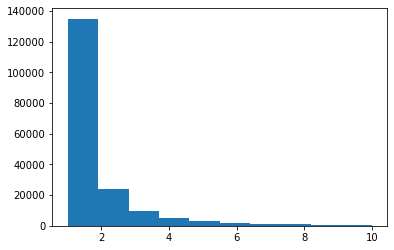

In [32]:
# Distribution of Ratings per User (quick look)
c = pd.DataFrame(user_ratings['ids'].value_counts())
plt.hist(c[c<11]);

We can see that the dataset is extremely skewed to the right in terms of the number of ratings per user<br>
Lets compare RMSEs while reducing trainSet to users with more than "n" number of ratings

In [ ]:
# get rmse scores and percent of orginial data while reducing users who rated atleast "n" games
min_num_ratings = []
rmse = []
percent_of_original_data = []
for n in range(30):
    user_set = user_ratings[user_ratings.ids.isin(counts.index[counts.gt(n)])] # take only users with more than n ratings
    reader = Reader(rating_scale=(0, 10))

    d = Dataset.load_from_df(user_set[['ids', 'game_id', 'rating']], reader)

    t = data.build_full_trainset()

    alg = NormalPredictor()

    cv = cross_validate(alg, d, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    score = cv['test_rmse'].mean()
    min_num_ratings.append(n)
    rmse.append(score)
    pct = users/len(user_ratings)
    percent_of_original_data.append(pct)

In [101]:
df = pd.DataFrame(min_num_ratings)
df['rmse'] = rmse
df['percent_of_original_data'] = percent_of_original_data

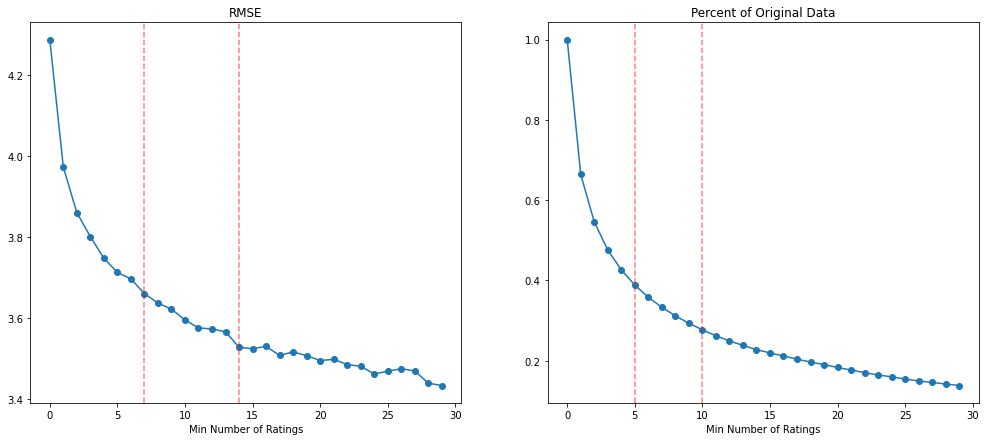

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].plot(df[0], df['rmse'], 'o-')
ax[0].set(xlabel='Min Number of Ratings', ylabel='', title='RMSE')
ax[0].axvline(x=7, c='r', ls='--', alpha=.5)
ax[0].axvline(x=14, c='r', ls='--', alpha=.5)
ax[1].plot(df[0], df['percent_of_original_data'], 'o-')
ax[1].set(xlabel='Min Number of Ratings', ylabel='', title='Percent of Original Data')
ax[1].axvline(x=5, c='r', ls='--', alpha=.5)
ax[1].axvline(x=10, c='r', ls='--', alpha=.5);

It is tough to say exactly what value would be appropriate to use as the minimum number of ratings. We can see that at a minimum of 7 and 14 there are relatively significant dips in the RMSE. Between 5 and 10 as a minimum the rate of loss of orginal data slows down. Taking the mean of the mean of these intervals gives us a values of 9. This is what we'll use 

In [71]:
# Our old to new dimensions
print(f'Old dimensions: {user_ratings.iloc[:,:3].shape[0]} rows, {user_ratings.iloc[:,:3].shape[1]} columns')
print(f'New dimensions: {data.df.shape[0]} rows, {data.df.shape[1]} columns')

Old dimensions: 401391 rows, 3 columns
New dimensions: 117621 rows, 3 columns


In [36]:
c = user_ratings.ids.value_counts()
user_set = user_ratings[user_ratings.ids.isin(c.index[c.gt(9)])] # take only users with more than n ratings
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(user_set[['ids', 'game_id', 'rating']], reader)
trainSet = data.build_full_trainset()

In [118]:
alg = NormalPredictor()
cv = cross_validate(alg, d, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.4432  3.4178  3.4618  3.4395  3.4817  3.4488  0.0216  
MAE (testset)     2.6965  2.6938  2.7181  2.7050  2.7279  2.7083  0.0130  
Fit time          0.07    0.09    0.18    0.12    0.12    0.12    0.04    
Test time         0.08    0.16    0.08    0.08    0.13    0.11    0.03    


In [38]:
anti_testset_user = []
targetUser = 0 #inner_id of the target user
fillValue = trainSet.global_mean
user_item_ratings = trainSet.ur[targetUser]
user_items = [item for (item,_) in (user_item_ratings)]
user_items
ratings = trainSet.all_ratings()
for iid in trainSet.all_items():
    if(iid not in user_items):
        anti_testset_user.append((trainSet.to_raw_uid(targetUser),trainSet.to_raw_iid(iid),fillValue))

In [49]:
# games and ratings of target user
test_user = user_ratings[user_ratings.ids==anti_testset_user[0][0]] # user id is at index 0 in each entry in the test set
test_user

,ids,game,rating,review,game_id
327,205,PlanetSide 2,10,Planetside 2 puts u in the real battlefield. W...,7282
328,205,Resogun,10,2nd Best launch title!!!!!!!!!!!!!!!!the game ...,7873
329,205,Knack,10,"Knack is a charmer,at first i was skeptical an...",5048
330,205,Need for Speed: Rivals,8,all the 10 reviews i bet are from ea!this gam...,6608
331,205,Dragon's Dogma: Dark Arisen,10,This game has one of the best if not arguably...,2755
332,205,D4: Dark Dreams Don't Die,10,my absolute favorite game on Xbone.It's unique...,2002
333,205,Velocity 2X,10,"This game,This game.Holy moly,this game's insa...",11007
334,205,NieR: Automata,10,NieR: Automata is the biggest sleeper hit of 2...,6695
335,205,Death Stranding: Director's Cut,10,Legit my favorite game ever made. I love the m...,2273
336,205,Destiny,0,This game has a lot of repetition.There is lit...,2361


In [20]:
# Baseline Predictions from random choices based off an assumed normal distribution of ratings
predictions = algo.test(anti_testset_user)
pred_df = pd.DataFrame(predictions)
pred_df.sort_values(by=['est'],inplace=True,ascending = False)
game_ids = pred_df.head(10)['iid'].to_list()
game_list = list(set(user_ratings[user_ratings.game_id.isin(game_ids)].game))

In [19]:
games = pd.read_csv('games_eda.csv').drop(['Unnamed: 0'],axis=1)

In [22]:
games[games.title.isin(game_list)]

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
838,Raw Data,2017-10-05,PC,Survios,NaN,NaN,87,6.6,7,10.0,Online Multiplayer,"Built from the ground up for VR, Raw Data’s ac...","Arcade, First-Person, Shooter, Action"
3855,Game of Thrones: Episode One - Iron From Ice,2014-12-03,Xbox One,Telltale Games,M,NaN,80,7.9,14,84.0,1 Player,Episode 1 - Iron From Ice. The series is based...,"Adventure, General, Point-and-Click, Action"
5695,Game of Thrones: Episode One - Iron From Ice,2014-12-02,PlayStation 4,Telltale Games,M,NaN,77,7.3,18,146.0,1 Player,Episode 1 - Iron From Ice. The series is based...,"Adventure, General, Point-and-Click, Action"
6691,Forza Horizon 4: LEGO Speed Champions,2019-06-13,Xbox One,Playground Games,E,NaN,77,5.7,7,61.0,1 Player,"Forza Horizon 4 LEGO Speed Champions, the seco...","Automobile, Simulation, Racing"
7528,Beach Spikers: Virtua Beach Volleyball,2002-08-12,GameCube,Sega AM2,E,NaN,76,8.3,31,14.0,1-4 Players,Beach Spikers delivers intense beach volleybal...,"Traditional, Volleyball, Sports"
7826,NCAA March Madness 2003,2002-11-21,PlayStation 2,NuFX,E,NaN,74,7.9,13,23.0,1-8 Players,Do you dream of cutting down the net in New Or...,"Basketball, Sim, Traditional, Sports"
9233,Game of Thrones: Episode One - Iron From Ice,2014-12-02,PC,Telltale Games,M,NaN,75,7.3,44,305.0,1 Player,Episode 1 - Iron From Ice. The series is based...,"Adventure, General, Point-and-Click, Action"
10747,Game & Watch Gallery 4,2002-10-28,Game Boy Advance,Nintendo,E,Comic Mischief,71,8.1,14,7.0,1-2 Players,Relive the birth of handheld gaming with over ...,"Compilation, Miscellaneous"
11897,Shenmue III,2019-11-19,PC,Ys Net,T,NaN,69,6.1,14,428.0,1 Player,"The story begins in 1980s Yokosuka, Japan.\r\n...","Open-World, Action Adventure"
13604,Shenmue III,2019-11-19,PlayStation 4,Ys Net,T,NaN,67,7.7,78,1107.0,1 Player,"The story begins in 1980s Yokosuka, Japan...Th...","Open-World, Action Adventure"


In [23]:
# KNN between game ratings
sim_options = {'name': 'cosine',
               'user_based': False  # compute similarities between game ratings
               }
algo = KNNBasic(sim_options=sim_options)
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...


C:\Users\trent\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning:

invalid value encountered in double_scalars



Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6129  2.6318  2.6197  2.5885  2.5987  2.6103  0.0153  
MAE (testset)     1.8829  1.8908  1.8914  1.8610  1.8863  1.8825  0.0112  
Fit time          34.06   16.14   10.60   9.04    9.25    15.82   9.48    
Test time         5.09    3.00    4.49    2.42    2.18    3.44    1.15    


{'test_rmse': array([2.61285413, 2.63177793, 2.61968392, 2.58851246, 2.59872004]),
 'test_mae': array([1.88293642, 1.8908028 , 1.89136394, 1.8610493 , 1.88630301]),
 'fit_time': (34.05531644821167,
  16.1353919506073,
  10.59906554222107,
  9.039827108383179,
  9.251705408096313),
 'test_time': (5.08773946762085,
  3.003500461578369,
  4.4890100955963135,
  2.4196367263793945,
  2.183750867843628)}

In [24]:
# KNN Predictions for user 0
predictions = algo.test(anti_testset_user)
pred_df = pd.DataFrame(predictions)
pred_df.sort_values(by=['est'],inplace=True,ascending = False)
game_ids = pred_df.head(10)['iid'].to_list()
game_list = list(set(user_ratings[user_ratings.game_id.isin(game_ids)].game))
games[games.title.isin(game_list)]

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
1661,DiRT Rally 2.0,2019-02-26,PC,Codemasters,E,NaN,84,5.0,22,135.0,Online Multiplayer Up to 8 Players,DiRT Rally 2.0 dares you to carve your way thr...,"Automobile, Simulation, Racing"
2312,DiRT Rally 2.0,2019-02-26,PlayStation 4,Codemasters,E,NaN,84,5.9,34,180.0,Up to 8 Players,DiRT Rally 2.0 dares you to carve your way thr...,"Automobile, Simulation, Racing"
3642,DiRT Rally 2.0,2019-02-26,Xbox One,Codemasters,E,NaN,82,7.3,21,51.0,Up to 8 Players,DiRT Rally 2.0 dares you to carve your way thr...,"Automobile, Simulation, Racing"
4196,Assetto Corsa Competizione,2022-02-22,PlayStation 5,505 Games,E,NaN,81,7.7,11,23.0,1 Player,Assetto Corsa Competizione is an extraordinary...,"Automobile, Simulation, Racing"
4738,Alba: a Wildlife Adventure,2021-06-09,Switch,ustwo,E,NaN,80,7.1,7,10.0,1 Player,From the BAFTA-Award winning studio behind Mon...,"General, Adventure"
6018,Alba: a Wildlife Adventure,2020-12-11,PC,ustwo,E,NaN,79,8.0,12,26.0,1 Player,"High Hell is a neon-soaked, arcade-action firs...","General, Adventure"
6182,Hot Wheels Unleashed,2021-09-30,PC,Milestone S.r.l,E,NaN,78,8.1,17,33.0,Up to 12 Players,"Drive the cars of your dreams! The coolest, th...","Arcade, Automobile, Racing"
7012,Assetto Corsa Competizione,2019-05-29,PC,Kunos Simulazioni,E,NaN,77,7.2,22,83.0,Online Multiplayer,Assetto Corsa Competizione is the new official...,"Automobile, Simulation, Racing"
7279,Assetto Corsa Competizione,2020-06-23,Xbox One,505 Games,E,NaN,76,4.8,11,19.0,Up to 20 Players,Assetto Corsa Competizione is an extraordinary...,"Automobile, Simulation, Racing"
7434,Hot Wheels Unleashed,2021-09-27,PlayStation 5,Milestone S.r.l,E,NaN,75,7.8,41,48.0,Up to 12 Players,"Drive the cars of your dreams! The coolest, th...","Arcade, Automobile, Racing"


In [27]:
# KNN between user ratings
sim_options = {'name': 'cosine',
               'user_based': True  # compute similarities between users
               }
algo = KNNBasic(sim_options=sim_options)
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...


C:\Users\trent\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning:

invalid value encountered in double_scalars



Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6767  2.7267  2.7131  2.6934  2.7065  2.7033  0.0171  
MAE (testset)     1.9576  2.0026  1.9861  1.9719  1.9893  1.9815  0.0154  
Fit time          2.93    2.74    2.91    3.09    2.64    2.86    0.16    
Test time         1.14    1.49    1.25    1.35    1.09    1.26    0.15    


{'test_rmse': array([2.67672202, 2.72670488, 2.71307537, 2.69340871, 2.70653564]),
 'test_mae': array([1.95760844, 2.00256072, 1.98606361, 1.97185412, 1.9892669 ]),
 'fit_time': (2.9307854175567627,
  2.742410898208618,
  2.906315803527832,
  3.09023118019104,
  2.6444592475891113),
 'test_time': (1.1353530883789062,
  1.4851486682891846,
  1.2473070621490479,
  1.3512272834777832,
  1.085378646850586)}

In [28]:
predictions = algo.test(anti_testset_user)
pred_df = pd.DataFrame(predictions)
pred_df.sort_values(by=['est'],inplace=True,ascending = False)
game_ids = pred_df.head(10)['iid'].to_list()
game_list = list(set(user_ratings[user_ratings.game_id.isin(game_ids)].game))
games[games.title.isin(game_list)]

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
10,Star Wars: Knights of the Old Republic,2003-07-17,Xbox,BioWare,T,Violence,94,9.1,72,462.0,1 Player,"Long before the Galactic Civil War, an epic dr...","Third-Person, Role-Playing"
77,Star Wars: Knights of the Old Republic,2003-11-18,PC,BioWare,T,Violence,93,9.0,33,2176.0,1 Player,Engage in this saga set in the Golden Age of t...,"General, Third-Person, Western-Style, Role-P..."
830,Tearaway,2013-11-22,PlayStation Vita,Media Molecule,E,NaN,87,8.9,82,468.0,1 Player,Adventure through a vibrant papery world with ...,"3D, Action, Adventure, General, Platformer..."
1533,Guitar Hero: Metallica,2009-03-29,PlayStation 3,Neversoft Entertainment,T,Lyrics Mild Suggestive Themes,86,8.1,44,59.0,1 Player,Guitar Hero: Metallica takes music fans throug...,"Miscellaneous, Music, Rhythm, Action"
1910,Guitar Hero: Metallica,2009-03-29,Wii,Neversoft Entertainment,T,Lyrics Mild Suggestive Themes,85,7.6,20,27.0,1 Player,Guitar Hero: Metallica takes music fans throug...,"Miscellaneous, Music, Rhythm, Action"
2296,Guitar Hero: Metallica,2009-03-29,Xbox 360,Neversoft Entertainment,T,Lyrics Mild Suggestive Themes,84,8.0,62,89.0,1 Player,Guitar Hero: Metallica takes music fans throug...,"Miscellaneous, Music, Rhythm, Action"
2328,Nobody Saves the World,2022-04-14,Switch,DrinkBox Studios,T,NaN,84,tbd,9,NaN,2 Players,"When the ancient Calamity re-awakens, who can ...","Action RPG, Role-Playing"
2513,Mega Man Zero,2002-09-09,Game Boy Advance,Inti,E,Violence,82,8.8,17,101.0,1 Player,It's your mission to help the exiled scientist...,"2D, Platformer, Action"
2741,To the Moon,2020-01-16,Switch,"Freebird Games, X.D. Network Inc.",T,NaN,84,8.3,16,67.0,1 Player,Dr. Rosalene and Dr. Watts have peculiar jobs:...,"General, Adventure"
3127,Star Wars: Knights of the Old Republic,2021-11-11,PC,Free Lives,NaN,NaN,83,8.0,32,328.0,1 Player,A ridiculously violent platform game about bei...,"2D, Action, Platformer, Platformer"


In [29]:
# SVD 
algo = SVD(random_state=0)
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2806  2.2909  2.2845  2.2953  2.3238  2.2950  0.0152  
MAE (testset)     1.6938  1.7022  1.6957  1.7099  1.7286  1.7060  0.0126  
Fit time          8.51    7.36    6.76    7.52    7.47    7.52    0.56    
Test time         0.22    0.22    0.21    0.52    0.22    0.28    0.12    


{'test_rmse': array([2.28059071, 2.29088118, 2.28451787, 2.29527177, 2.32375278]),
 'test_mae': array([1.69382467, 1.70222634, 1.69565306, 1.70987419, 1.72860683]),
 'fit_time': (8.505151271820068,
  7.364152193069458,
  6.764128923416138,
  7.5196967124938965,
  7.466724634170532),
 'test_time': (0.22287273406982422,
  0.22087383270263672,
  0.2088789939880371,
  0.5197041034698486,
  0.21787619590759277)}

In [26]:
# SVD Predictions
predictions = algo.test(anti_testset_user)
pred_df = pd.DataFrame(predictions)
pred_df.sort_values(by=['est'],inplace=True,ascending = False)
game_ids = pred_df.head(10)['iid'].to_list()
game_list = list(set(user_ratings[user_ratings.game_id.isin(game_ids)].game))
games[games.title.isin(game_list)]

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
8,Madden NFL 2004,2003-08-12,GameCube,EA Tiburon,E,NaN,94,7.0,19,30.0,1-4 Players,"In its 14th season, Madden NFL Football isn't ...","Football, Sim, Traditional, Sports"
15,Super Mario 64,1996-09-26,Nintendo 64,Nintendo,E,NaN,94,9.1,13,1548.0,1 Player,Mario is super in a whole new way! Combining t...,"3D, Platformer, Action"
131,Yakuza 0,2020-02-26,Xbox One,Ryu ga Gotoku Studios,M,NaN,90,8.1,9,207.0,1 Player,"Tokyo 1988. Getting rich is easy, the women ar...","Open-World, Action Adventure"
138,Rayman Legends,2013-09-03,Xbox 360,Ubisoft Montpellier,E10+,NaN,90,6.7,30,367.0,1 Player,"For many months now, our team at BioWare has b...","2D, Platformer, Action"
286,Madden NFL 2004,2003-08-12,PlayStation 2,EA Tiburon,E,NaN,94,8.3,29,149.0,1-8 Players,[Metacritic's 2003 Playstation 2 Game of the Y...,"Football, Sim, Traditional, Sports"
376,Rayman Legends,2013-09-03,PlayStation 3,Ubisoft Montpellier,E10+,Cartoon Violence Comic Mischief Mild Cartoon V...,91,8.7,23,380.0,1 Player,Rayman Legends is the follow-up to Rayman Orig...,"2D, Platformer, Action"
392,Madden NFL 2004,2003-08-12,PC,EA Tiburon,E,NaN,91,7.1,13,28.0,1-8 Players,Key Features for 2004 include New Playmaker Co...,"Football, Sim, Team, Traditional, Sports"
473,Dishonored,2012-10-09,Xbox 360,Arkane Studios,M,Blood and Gore Intense Violence Sexual Themes ...,88,7.9,56,920.0,1 Player,Dishonored is a tactile first-person action ga...,"General, Modern, Action Adventure"
567,Dishonored,2012-10-09,PlayStation 3,Arkane Studios,M,Blood and Gore Intense Violence Sexual Themes ...,89,7.9,35,931.0,1 Player,The action in Dishonored takes place in Dunwal...,"General, Modern, Action Adventure"
611,Madden NFL 2004,2003-08-12,Xbox,EA Tiburon,E,NaN,92,7.6,27,52.0,1-4 Players,"In its 14th season, Madden NFL Football isn't ...","Football, Sim, Traditional, Sports"


In [72]:
algorithms = ['Normal Predictor', 'KNNBasic (User-based)', 'KNNBasic (Item-based)', 'SVD']
rmse_scores = [3.44, 2.70, 2.61, 2.3]
algo_compare = pd.DataFrame(zip(algorithms, rmse_scores)).rename(columns={0:'Algorithm', 1:'RMSE Score'})

In [73]:
fig = px.bar(algo_compare, x = algo_compare['RMSE Score'], y=algo_compare['Algorithm'], text = algo_compare['RMSE Score'])
fig.update_layout(yaxis=dict(title=''), xaxis=dict(title='RMSE'))
# fig.update_traces(textposition='outside')
fig.show()

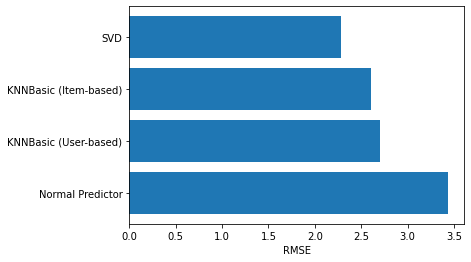

In [3]:
# Model Scores (quick look)
plt.barh(algo_compare['Algorithm'], algo_compare['RMSE Score'])
plt.xlabel('RMSE');

We will use SVD as our main algorithm

In [44]:
# Parameter Tuning with GridSearch for SVD 
param_grid = {'n_factors': [100,150],
              'n_epochs': [20,25,30],
              'lr_all':[0.005,0.01,0.1],
              'reg_all':[0.02,0.05,0.1],
              'random_state':[0]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3)
gs.fit(data)     

In [47]:
gs.best_score

{'rmse': 2.300407373649707, 'mae': 1.7162267074213997}

In [46]:
gs.best_params

{'rmse': {'n_factors': 100,
  'n_epochs': 25,
  'lr_all': 0.005,
  'reg_all': 0.1,
  'random_state': 0},
 'mae': {'n_factors': 100,
  'n_epochs': 30,
  'lr_all': 0.005,
  'reg_all': 0.1,
  'random_state': 0}}

In [121]:
algo = gs.best_estimator['rmse']

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2827  2.2634  2.2764  2.2890  2.3021  2.2827  0.0129  
MAE (testset)     1.6951  1.6861  1.6927  1.7040  1.7128  1.6981  0.0093  
Fit time          9.96    8.44    9.77    8.71    8.59    9.09    0.64    
Test time         0.27    0.58    0.25    0.23    0.22    0.31    0.14    


{'test_rmse': array([2.28270621, 2.26335616, 2.27635638, 2.289031  , 2.30206026]),
 'test_mae': array([1.69511863, 1.68612789, 1.69270057, 1.70398862, 1.71275926]),
 'fit_time': (9.96087646484375,
  8.437171220779419,
  9.772512674331665,
  8.7050199508667,
  8.589082717895508),
 'test_time': (0.26629137992858887,
  0.5836646556854248,
  0.2488558292388916,
  0.22788429260253906,
  0.22287511825561523)}

In [50]:
algo = gs.best_estimator['mae']

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2848  2.2767  2.2934  2.2935  2.2904  2.2878  0.0064  
MAE (testset)     1.6942  1.6883  1.7051  1.7103  1.6957  1.6987  0.0079  
Fit time          14.43   14.97   15.31   13.39   12.41   14.10   1.07    
Test time         0.46    0.28    0.26    0.29    0.24    0.31    0.08    


{'test_rmse': array([2.28479978, 2.27672493, 2.29339957, 2.29348391, 2.29042982]),
 'test_mae': array([1.69416419, 1.68830871, 1.70514465, 1.71030577, 1.69568667]),
 'fit_time': (14.431212425231934,
  14.974238395690918,
  15.30686902999878,
  13.385952472686768,
  12.412360668182373),
 'test_time': (0.4582977294921875,
  0.27784132957458496,
  0.26485395431518555,
  0.286834716796875,
  0.24487090110778809)}

We have marginally improved our results

In [16]:
import pickle

In [17]:
# pickle.dump(gs, open('surprise_grid_search_svd.sav', 'wb'))
gs = pickle.load(open('surprise_grid_search_svd.sav', 'rb'))

In [62]:
algo = gs.best_estimator['rmse']
predictions = algo.test(anti_testset_user)
pred_df = pd.DataFrame(predictions)
pred_df.sort_values(by=['est'],inplace=True,ascending = False)
game_ids = pred_df.head(10)['iid'].to_list()
game_list = list(set(user_ratings[user_ratings.game_id.isin(game_ids)].game))
game_preds = games[games.title.isin(game_list)]
game_preds#.drop(columns=['critic_reviews', 'user_reviews'])

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,critic_reviews,user_reviews,num_players,summary,genres
46,Okami,2006-09-19,PlayStation 2,Clover Studio,T,Blood and Gore Crude Humor Fantasy Violence Su...,93,9.1,69,496.0,1 Player,"In Okami, the legendary monster Orochi has com...","Fantasy, Action Adventure"
253,Baldur's Gate II: Shadows of Amn,2000-09-24,PC,BioWare,T,Animated Blood Animated Violence Use of Alcoho...,95,9.1,30,1506.0,"1-6 Players, Up to 6 Players",An epic continuation of the story that began i...,"PC-style RPG, Western-Style, Role-Playing"
285,Sid Meier's Civilization II,1996-02-29,PC,MPS Labs,K-A,Mild Animated Violence,94,8.8,7,486.0,1 Player,An empire-building turn-based strategy game. T...,"4X, General, Historic, Turn-Based, Strategy"
365,Planescape: Torment,1999-12-14,PC,Black Isle Studios,T,Animated Blood Suggestive Themes Violence,91,9.2,22,1097.0,1 Player,"Welcome to Sigil, the ""City of Doors"", a place...","General, PC-style RPG, Western-Style, Role-P..."
614,Warcraft III: Reign of Chaos,2002-07-03,PC,Blizzard Entertainment,T,Animated Violence Blood Violence,92,9.2,40,2273.0,1 Player,[Metacritic's 2002 PC Game of the Year] It has...,"Fantasy, General, Real-Time, Strategy"
623,System Shock 2,1999-08-11,PC,"Looking Glass Studios, Irrational Games",M,Animated Blood & Gore Animated Blood and Gore ...,92,9.1,20,682.0,1 Player,"Like System Shock 1, there will be persistent ...","Sci-Fi, Survival, Action Adventure"
720,Warcraft III: The Frozen Throne,2003-07-01,PC,Blizzard Entertainment,T,Blood Violence,88,9.2,23,1735.0,1-12 Players,The Frozen Throne provides gamers with a vast ...,"Fantasy, General, Real-Time, Strategy"
725,Starcraft,1998-03-31,PC,Blizzard Entertainment,T,Animated Blood & Gore Animated Blood and Gore ...,88,9.1,15,1210.0,1-8 Players,In the distant future a small group of human e...,"Command, Real-Time, Sci-Fi, Strategy"
1340,Dance Dance Revolution,2001-05-09,PlayStation,Konami,E,NaN,90,8.4,8,107.0,1-2 Players,Dance Dance Revolution brings the dance floor ...,"Dancing, Rhythm, Miscellaneous"
1370,Deus Ex,2000-06-23,PC,Ion Storm,M,Animated Blood Animated Violence,90,9.2,28,1472.0,"1 Player, Online Multiplayer","The game that incorporates RPG, action, advent...","General, Sci-Fi, Action Adventure"


As we can see, if I gathered the platform for each review, I could have attached the platform to the title to make it a completely seperate game (which it is). Therefore, the recommendations wouldn't be generalized to just the titles. I could have also collected the date of each review to only recommend games within the range of the review dates.

In [46]:
game_preds.drop_duplicates('title').drop('critic_reviews', axis=1)

,title,release_date,platforms,developer,esrb_rating,ESRBs,metascore,userscore,user_reviews,num_players,summary,genres
46,Okami,2006-09-19,PlayStation 2,Clover Studio,T,Blood and Gore Crude Humor Fantasy Violence Su...,93,9.1,496.0,1 Player,"In Okami, the legendary monster Orochi has com...","Fantasy, Action Adventure"
253,Baldur's Gate II: Shadows of Amn,2000-09-24,PC,BioWare,T,Animated Blood Animated Violence Use of Alcoho...,95,9.1,1506.0,"1-6 Players, Up to 6 Players",An epic continuation of the story that began i...,"PC-style RPG, Western-Style, Role-Playing"
285,Sid Meier's Civilization II,1996-02-29,PC,MPS Labs,K-A,Mild Animated Violence,94,8.8,486.0,1 Player,An empire-building turn-based strategy game. T...,"4X, General, Historic, Turn-Based, Strategy"
365,Planescape: Torment,1999-12-14,PC,Black Isle Studios,T,Animated Blood Suggestive Themes Violence,91,9.2,1097.0,1 Player,"Welcome to Sigil, the ""City of Doors"", a place...","General, PC-style RPG, Western-Style, Role-P..."
614,Warcraft III: Reign of Chaos,2002-07-03,PC,Blizzard Entertainment,T,Animated Violence Blood Violence,92,9.2,2273.0,1 Player,[Metacritic's 2002 PC Game of the Year] It has...,"Fantasy, General, Real-Time, Strategy"
623,System Shock 2,1999-08-11,PC,"Looking Glass Studios, Irrational Games",M,Animated Blood & Gore Animated Blood and Gore ...,92,9.1,682.0,1 Player,"Like System Shock 1, there will be persistent ...","Sci-Fi, Survival, Action Adventure"
720,Warcraft III: The Frozen Throne,2003-07-01,PC,Blizzard Entertainment,T,Blood Violence,88,9.2,1735.0,1-12 Players,The Frozen Throne provides gamers with a vast ...,"Fantasy, General, Real-Time, Strategy"
725,Starcraft,1998-03-31,PC,Blizzard Entertainment,T,Animated Blood & Gore Animated Blood and Gore ...,88,9.1,1210.0,1-8 Players,In the distant future a small group of human e...,"Command, Real-Time, Sci-Fi, Strategy"
1340,Dance Dance Revolution,2001-05-09,PlayStation,Konami,E,NaN,90,8.4,107.0,1-2 Players,Dance Dance Revolution brings the dance floor ...,"Dancing, Rhythm, Miscellaneous"
1370,Deus Ex,2000-06-23,PC,Ion Storm,M,Animated Blood Animated Violence,90,9.2,1472.0,"1 Player, Online Multiplayer","The game that incorporates RPG, action, advent...","General, Sci-Fi, Action Adventure"
